# Classify Catmon Image From Twitter Stream Using VGG16 CNN Model

## Set-up

In [43]:
import os
import requests
import sys
import tweepy

from configparser import ConfigParser
from io import BytesIO
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms
from torchvision import models

In [44]:
print(f"tweepy version: {tweepy.__version__}")
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

tweepy version: 4.10.0
torch version: 1.10.0
torchvision version: 0.11.1


In [45]:
# define key twitter info
BOOSIMBA_TWITTER_CONFIG_FILE = 'catmonic_twitter.ini' 
BOOSIMBA_TWITTER_USER_ID = 3022268453

In [46]:
# define model class names
class_names = ['boo', 'simba', 'unknown']
print(f"total of {len(class_names)}: {class_names}")

total of 3: ['boo', 'simba', 'unknown']


In [47]:
# define image transform
# - as used during model transfer learning, training and test
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [48]:
# define model state dict containing key paramaters
VGG16_MODEL_SD = "models/catmon-img-classifier_vgg16_state_dict_0.1"

In [68]:
# define location of cat test images
BOO_IMAGE = "images/unseen_boo_image_2015-03-08_141742.jpg"
SIMBA_IMAGE = "images/unseen_simba_image_2015-05-10_180756.jpg"
UNKNOWN_IMAGE = "images/unseen_unknown_image_2015-05-10_044850.jpg"

## Prepare model, load the saved model params from state dict

In [69]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device is: {device}")

# Instantiate the model
# model = models.vgg16(pretrained=True)
model = models.vgg16()

# Extract number of input and output features from the model
num_features = model.classifier[-1].in_features

# Update model classifier to take account of number of classes (here 3)
num_classes = len(class_names)
model.classifier[-1] = nn.Linear(num_features, num_classes)
print(f"number of model features is: {num_features}, number of classes (labels) is: {num_classes}")

# load state dict for trained model
model.load_state_dict(torch.load(VGG16_MODEL_SD))

device is: cpu
number of model features is: 4096, number of classes (labels) is: 3


<All keys matched successfully>

In [70]:
# place in evaluation mode
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [71]:
# check modified classifier (expect in_features=num_features and out_features=num_classes)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

## Check model prediction with new catmon images

In [72]:
# define helper function to show given input tensor
# ref: catmon image classifier iteration1 vgg16
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(1)

In [73]:
# define helper function to predict catmon image
# ref: catmon image classifier iteration1 vgg16
def predict_catmon_image(model, class_names, transform, device, pil_image, display=True):
    """Return predicted label and probability for given model and pil image.
    
    If display is True,
    Display image with predicted label and probability percentage, 
    
    """
    
    # apply transform to create the required tensor
    tensor = transform(pil_image)
    
    # reshape tensor to add dummy batch
    reshaped_tensor = tensor.unsqueeze(0)
    print(reshaped_tensor.shape)
    
    # classify the image
    with torch.no_grad():

        inputs = reshaped_tensor.to(device)
        outputs = model(inputs)
        probs, preds = torch.max(outputs, 1)

        # calculate probabilities using softmax
        sm = torch.nn.Softmax(dim=1)
        probabilities = sm(outputs).flatten().numpy()
        print(preds, probabilities)
        
        label = class_names[preds]
        probability = float(probabilities[preds])
        print(label, probability)

    if display:
        img = inputs.data[0]
        imshow(img, f"predicted: {label} ({probability:.1%})")
    
    return label, probability

torch.Size([1, 3, 224, 224])
tensor([0]) [9.9999583e-01 4.1441117e-06 3.3142713e-23]
boo 0.9999958276748657


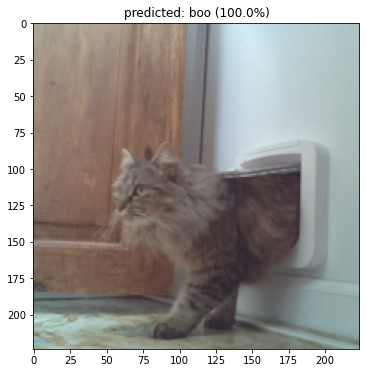

CPU times: total: 2.8 s
Wall time: 2.88 s


('boo', 0.9999958276748657)

In [74]:
%%time
# test model prediction with boo image
# first convert jpg to pil
pil_image = Image.open(BOO_IMAGE)
# predict
predict_catmon_image(model, class_names, transform, device, pil_image, display=True)

torch.Size([1, 3, 224, 224])
tensor([1]) [6.1548207e-08 9.9999988e-01 3.6190546e-15]
simba 0.9999998807907104


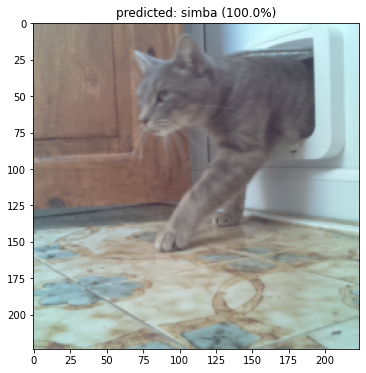

CPU times: total: 2.2 s
Wall time: 2.23 s


('simba', 0.9999998807907104)

In [75]:
%%time
# test model prediction with simba image
# first convert jpg to pil
pil_image = Image.open(SIMBA_IMAGE)
# predict
predict_catmon_image(model, class_names, transform, device, pil_image, display=True)

torch.Size([1, 3, 224, 224])
tensor([2]) [5.3713287e-09 3.0364506e-11 1.0000000e+00]
unknown 1.0


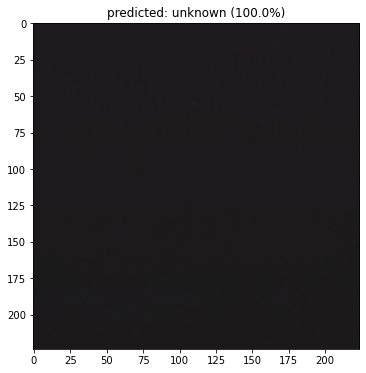

CPU times: total: 2.02 s
Wall time: 2.14 s


('unknown', 1.0)

In [76]:
%%time
# test model prediction with simba image
# first convert jpg to pil
pil_image = Image.open(UNKNOWN_IMAGE)
# predict
predict_catmon_image(model, class_names, transform, device, pil_image, display=True)

## Prepare twitter access

In [77]:
# define helper function to read auth info from ini file
# ref: Explore Twitter API
def get_auth_info(TWITTER_CONFIG_FILE):
    """Return twitter account name and auth info for twitter access."""
 
    config_path = os.path.abspath(TWITTER_CONFIG_FILE)

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Unexpected error, config file '{TWITTER_CONFIG_FILE}' not found.")

    # parse the config file and read key twitter info
    cfg = ConfigParser()
    cfg.read(config_path)

    account_name = cfg.get('twitter', 'account_name') 
    consumer_key = cfg.get('twitter', 'consumer_key')
    consumer_secret = cfg.get('twitter', 'consumer_secret')
    access_token = cfg.get('twitter', 'access_token')
    access_token_secret = cfg.get('twitter', 'access_token_secret')
    
    auth_info = (
        consumer_key,
        consumer_secret,
        access_token,
        access_token_secret
    )
    
    return account_name, auth_info

In [78]:
# get twitter account name and auth info
account_name, auth_info = get_auth_info(BOOSIMBA_TWITTER_CONFIG_FILE)
assert account_name == 'boosimba', f"Unexpected error, account_name '{account_name}' not recognised"
#print(auth_info)

In [79]:
# use auth info to establish api
auth = tweepy.OAuth1UserHandler(*auth_info)
api = tweepy.API(auth)

In [80]:
# test api, get the user object for boosimba...
user = api.get_user(screen_name=account_name)
# show location
user.location

'UK'

In [81]:
# define helper function to reply to a tweet
# ref: Explore Twitter API
def reply_to_tweet(api, id, text):
    """Use api to reply to given tweet id with given text."""

    try:
        api.update_status(
                status = text, 
                in_reply_to_status_id = id, 
                auto_populate_reply_metadata=True
        )
    except TypeError as e:
        print(f"Unexpected error replying on given api to tweet id {id} with text ''{text}' (error={e}, type={type(e)}")
        raise
        
def get_tweet_thread(api, username, id):
    replies = tweepy.Cursor(
        api.search_tweets, 
        q='to:{}'.format(username),
        since_id=id, 
        tweet_mode='extended'
    ).items()
    
    replied_thread = list()
    for reply in replies:
        if(reply._json['in_reply_to_status_id'] == id):
             replied_thread.append(reply._json['full_text'])
        
    return(replied_thread)

In [82]:
# test with reply to tweet containing 'Boo chased a fox!'
# https://stackoverflow.com/questions/9322465/reply-to-tweet-with-tweepy-python
TWEET_REPLY = True
TWEET_ID = 1541050269101858816
TWEET_TEXT = 'Simba ran away'
if not TWEET_REPLY:
    reply_to_tweet(api, TWEET_ID, TWEET_TEXT)
else:
    print('already replied')

already replied


In [83]:
# show reply (maybe empty if too old)
get_tweet_thread(api, 'boosimba', TWEET_ID)

[]

## Define and run tweet handler
- on boosimba catmon tweet, classify associated image and post reply with cat label (if known)

In [84]:
# https://stackoverflow.com/questions/22675561/using-tweepy-to-stream-users-timeline-and-filtered-tweets
# https://web.archive.org/web/20140704092006/http://answers.oreilly.com/topic/2605-how-to-capture-tweets-in-real-time-with-twitters-streaming-api
class BooSimbaTweetHandler(tweepy.Stream):
    
    def __init__(self, model, transform, device, *auth_info, **kwargs):
        self.model = model
        self.transform = transform
        self.device = device
        auth = tweepy.OAuth1UserHandler(*auth_info)
        self.api = tweepy.API(auth)
        super().__init__(*auth_info, **kwargs)
        
    def _predict_catmon_image(self, model, transform, device, pil_image):
        """Transform pil image, apply model and return predicted label and probability."""

        # apply transform to create the required tensor
        tensor = transform(pil_image)

        # reshape tensor to add dummy batch
        reshaped_tensor = tensor.unsqueeze(0)
    
        # classify the image
        with torch.no_grad():

            inputs = reshaped_tensor.to(device)
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)

            # calculate probabilities using softmax
            sm = torch.nn.Softmax(dim=1)
            probabilities = sm(outputs) 

            label = class_names[preds]
            probability = float(probabilities.flatten()[preds])
            
        return label, probability
          
    def _image_download(self, media_url):
        """Return downloaded pil image at given media_url."""
        response = requests.get(media_url)
        pil_img = Image.open(BytesIO(response.content))
        
        return pil_img
    
    def _reply_to_tweet(self, api, id, text):
        """Use api to post text as reply to tweet with given id."""

        try:
            api.update_status(
                    status = text, 
                    in_reply_to_status_id = id, 
                    auto_populate_reply_metadata=True
            )
        except TypeError as e:
            print(f"Unexpected error replying on given api to tweet id {id} with text ''{text}' (error={e}, type={type(e)}")
            raise

    def _handle_tweet(self, tweet):
        """Classify image in boosimba catmon auto-tweet."""
        BOOSIMBA_TWITTER_USER_ID = 3022268453
        BOOSIMBA_AUTOTWEET_TEXT = 'auto-tweet from catmon'
        BOOSIMBA_CAT_LABELS = ['boo', 'simba'] # excludes the 'unknown' label
        print('\n', '-'*60)
        print(f"tweet detected from {tweet.user.name} (user id={tweet.user.id}): {tweet.text} (tweet id={tweet.id})")
        if tweet.user.id == BOOSIMBA_TWITTER_USER_ID and tweet.text.startswith(BOOSIMBA_AUTOTWEET_TEXT):
            print("\tdownload image and classify...")
            media_url = tweet.entities['media'][0]['media_url']
            pil_image = self._image_download(media_url)
    
            # display half-size image 
            w, h = pil_image.size
            display(pil_image.resize((int(w/2), int(h/2))))
            
            label, proba = self._predict_catmon_image(self.model, self.transform, self.device, pil_image)
            if label in BOOSIMBA_CAT_LABELS:
                reply_text = (
                    f"Hello {label.capitalize()}\n\n\n"
                    f"[probability: {proba:.1%}, image automatically identified by the catmon image classifier cnn]"
                )
                print(f"tweet reply: {reply_text}")
                self._reply_to_tweet(self.api, tweet.id, reply_text)
            else: # label is 'unknown'
                print("Cat cannot be identified")
        
    def on_status(self, tweet):
        self._handle_tweet(tweet)
        
    def on_error(self, status_code):
        print(f"Error detected: {status_code}")
        return True # Don't kill the stream

    def on_timeout(self):
        print(f"Timeout detected")
        return True # Don't kill the stream

In [85]:
# get twitter account name and auth info
account_name, auth_info = get_auth_info(BOOSIMBA_TWITTER_CONFIG_FILE)
assert account_name == 'boosimba', f"Unexpected error, account_name '{account_name}' not recognised"

# instantiate the boosimba tweet stream handler to classify the catmon auto-tweet images
boosimba_tweet_handler = BooSimbaTweetHandler(model, transform, device, *auth_info)

# run the handler, following the boosimba id
print("Handling boosimba tweets...")
boosimba_tweet_handler.filter(follow=[BOOSIMBA_TWITTER_USER_ID])

Handling boosimba tweets...


KeyboardInterrupt: 